## Общая информация о соревновании


### Ссылка на соревнование:
https://www.kaggle.com/competitions/anomaly-detection-competition-ml1-ts-spring-2022/overview

#### Наша команда: Na chille, na rasslabone

#### Описание соревнования:
Во множестве прикладных задач возникает необходимость разбить веб-страницы на какие-то определенные группы, где в каждой группе страницы будут очень похожи по смыслу. Например, представим, что Вы владелец сервиса интернет рекламы. Вашим клиентам хочется, чтобы их услуги рекламировались не на каком-то определенном сайте, а на всех сайтах их тематики. То есть Вам нужна какая-то тематическая разметка сайтов в интернете по множеству тематик, и клиент сможет выбрать любую, какая ему больше нравится. Как же такую разметку сделать?

Самый простой способ - разметить людьми множество сайтов в интернете на множество тем, настроить на этой выборке многоклассовый классификатор и сделать предсказанием на всем оставшемся "интернете". Однако, в таком подходе возникает несколько проблем. Во-первых, непонятно откуда брать само множество тем, на которое размечать. Во-вторых, даже если множество тем зафиксировано, не очень понятно, откуда для каждой темы брать примеры, чтобы добавить их в обучающее множество.

В данном задании мы предлагаем Вам попробовать другое решение. Пусть тематику задают сами данные! Разделим наши веб-страницы на множество групп, например, просто по словам в веб-страницах. В такой группе буду как документы об одном и том же, так и "аномалии", которые имеют схожие слова, но не соответствуют документам основной тематики. Например, в такой группе может содержаться подмножество веб-страниц про "ремонт пластиковых окон" и аномалии вроде "пластиковые игрушки", "ремонт квартир" и так далее. Нам останется только выделить подмножество документов одной темы, то есть все документы, которые про "ремонт пластовых окон" и убрать все аномалии. Затем подмножество как-то проименуем, чтобы показать клиенту, но этим Вы уже займетесь, когда будете продавать Вашу систему :)

В задании Вам предлагается работать с 28026 веб-страницами, которые уже скачаны и лежат в архиве content.tar.gz. Эти страницы разбиты по группам, каждая группа около 100 страниц. Каждая группа соответствует какой-то определенной теме, которая Вам неизвестна. Обучающее множество состоит из 129 групп. В обучающих группах ручной разметкой было проставлено, соответствует ли данный документ теме группы (target = 1) или это аномалия (target = 0). Тестовое множество состоит из 180 групп. Вам необходимо проставить для них target. Важно отметить, что обучающие и тестовые группы не пересекаются. Гарантируется, что в каждой группе есть подмножество документов из ее темы.


In [32]:
import requests
import logging
import gzip
import json
import codecs
import re
import regex
import tarfile
import os.path

import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from multiprocessing.dummy import Pool, Queue
from bs4 import BeautifulSoup
from time import sleep
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from bs4.element import Comment
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score

from pymorphy2 import MorphAnalyzer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Обрабатываем html странички

Функции для обработки текста html страничек. 
Вытаскиваем заголовки и текст страниц, убираем все знаки кроме букв. К заголовкам применяем лемматизаци, а к тексту стемминг(применять лемматизацию к тексту было затратно). Для каждой страгички сохраняем обработанный заголовок, 50 самых часто встречаемых слов в тексте стрвницы, количество слов в заголовке и количество значимых слов в тексте.

In [2]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]', 'option']:
        return False
    if isinstance(element, Comment):
        return False
    return True

In [3]:
def get_title_and_text(doc_id):
    """
        Get set of words from title
        and most common words from text
    """
    page = open("content/" + str(doc_id) + ".dat", 'r', encoding='utf-8').read()
    soup = BeautifulSoup(page, 'html.parser')
    
    stemmer = SnowballStemmer("russian")
    morph = MorphAnalyzer()
    title = soup.title.text
    
    reg = regex.compile('[^a-zA-Zа-яА-Я ]')
    stop = set(stopwords.words('russian'))
    new_title = ' '.join([morph.normal_forms(w.lower())[0] for w in reg.sub('', title).strip().split() if (not (w.lower() in stop))])

    txt = soup.findAll(text=True)
    visible = filter(tag_visible, txt)
    txt = u" ".join(t.strip() for t in visible)

    txt = reg.sub('', txt)
    words = [stemmer.stem(word) for word in txt.split() if (not (word in stop)) and len(word) > 1]
    cnt = Counter(words)

    return (new_title, ' '.join(dict(cnt.most_common(50)).keys()), len(words))

In [4]:
def process_page(pair_id):
    """
        Get information about pair (doc, group):
        - doc_id - номер документа,
        - title - множество слов из заголовка страницы,
        - text - множество из 50 самых частых слов текста страницы,
        - target.
    """
    new_doc = train_data.loc[pair_id]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    try:
        title, text, size_text = get_title_and_text(doc_id)
    except:
        title, text, size_text = '', '', 0
    if doc_group not in traingroups_data:
        traingroups_data[doc_group] = []
    traingroups_data[doc_group].append((doc_id, title, text, len(title), size_text, target))
    return (doc_id, title, text, len(title), size_text, target)

### Реализация обработки всех страниц из обучающей выборки в несколько потоков

In [185]:
queue_groups = Queue()   # очередь ссылок на группы
train_data = pd.read_csv('train_groups.csv')
traingroups_data = {}
train_data.index = train_data.pair_id

groups_to_process = [29]

# Create queue of groups and n_groups queues of pair_ids in group
queue = {i: Queue() for i in groups_to_process}# gtrain_data.group_id.unique()}
for group in groups_to_process:# train_data.group_id.unique():
    queue_groups.put(group)
    for pair in train_data[train_data.group_id == group].itertuples():
        queue[group].put(pair.pair_id)
#for pair in train_data[train_data.group_id == 1].itertuples():
#    queue.put(pair.pair_id)

#pages_data = {i:[] for i in groups_to_process}# train_data.group_id.unique()

#zipfile = 'content.tar.gz'
#tar = tarfile.open(zipfile, "r:gz") # Считывает архив с данными

def extract_pages(group):
    """
        Extract pages data from .gz archive if not extracted
    """
    for pair in train_data[train_data.group_id == group].itertuples():
        if not os.path.exists("content/" + str(pair.doc_id) + ".dat"):
            tar.extract("content/" + str(pair.doc_id) + ".dat")

def process_page_wrapper(i):
    while not queue_groups.empty():
        group = int(queue_groups.get())
        #extract_pages(group)
        with open('data_2/group_{:03d}.txt'.format(group), mode='wb') as f_json:
            f_json = codecs.getwriter('utf_16')(f_json)
            record = {}
            while not queue[group].empty():
                pair_id = queue[group].get()
                doc_id, title, text, size_title, size_text, target = process_page(pair_id)
                record[pair_id] = {'doc_id': int(doc_id), 'title': title, 'text': text, 'size_title': size_title, 'size_text': size_text,' target': int(target)}
                #print(record[pair_id]) 
                #pages_data[group].append((doc_id, title, text, size_title, target))
            record_str = json.dumps(record, indent=4, ensure_ascii=False)
            print(record_str, file=f_json) 
            with lock:
                pbar.update(1)


with Pool(processes=4) as pool, tqdm(total=queue_groups.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_page_wrapper, range(pool._processes))
    pool.close()
    pool.join()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.08s/it]


### Делаем такую же обработку в несколько потоков для страниц из тестовой выборки

In [5]:
def process_page_test(pair_id):
    """
        Get information about pair (doc, group):
        - doc_id - номер документа,
        - title - множество слов из заголовка страницы,
        - text - множество из 50 самых частых слов текста страницы,
        - target.
    """
    new_doc = test_data.loc[pair_id]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    try:
        title, text, size_text = get_title_and_text(doc_id)
    except:
        title, text, size_text = '', '', 0
    #title = doc_to_title[doc_id]
    if doc_group not in traingroups_data:
        testgroups_data[doc_group] = []
#     traingroups_data[doc_group].append((doc_id, title, text, target))
#     return (doc_id, title, text, target)
    testgroups_data[doc_group].append((doc_id, title, text, len(title), size_text))
    return (doc_id, title, text, len(title), size_text)

In [197]:
queue_groups = Queue()   # очередь ссылок на группы
test_data = pd.read_csv('test_groups.csv')
testgroups_data = {}
test_data.index = test_data.pair_id

groups_to_process = [133, 239, 307]

# Create queue of groups and n_groups queues of pair_ids in group
queue = {i: Queue() for i in groups_to_process}# gtrain_data.group_id.unique()}
for group in groups_to_process:# train_data.group_id.unique():
    queue_groups.put(group)
    for pair in test_data[test_data.group_id == group].itertuples():
        queue[group].put(pair.pair_id)
#for pair in train_data[train_data.group_id == 1].itertuples():
#    queue.put(pair.pair_id)

#pages_data = {i:[] for i in groups_to_process}# train_data.group_id.unique()

#zipfile = 'content.tar.gz'
#tar = tarfile.open(zipfile, "r:gz") # Считывает архив с данными

def extract_pages(group):
    """
        Extract pages data from .gz archive if not extracted
    """
    for pair in test_data[test_data.group_id == group].itertuples():
        if not os.path.exists("content/" + str(pair.doc_id) + ".dat"):
            tar.extract("content/" + str(pair.doc_id) + ".dat")

def process_page_wrapper(i):
    while not queue_groups.empty():
        group = int(queue_groups.get())
        #extract_pages(group)
        with open('data_test/group_{:03d}.txt'.format(group), mode='wb') as f_json:
            f_json = codecs.getwriter('utf_16')(f_json)
            record = {}
            while not queue[group].empty():
                pair_id = queue[group].get()
                doc_id, title, text, size_title, size_text = process_page_test(pair_id)
                record[pair_id] = {'doc_id': int(doc_id), 'title': title, 'text': text, 'size_title': size_title, 'size_text': size_text}
                #print(record[pair_id]) 
                #pages_data[group].append((doc_id, title, text, size_title, target))
            record_str = json.dumps(record, indent=4, ensure_ascii=False)
            print(record_str, file=f_json) 
            with lock:
                pbar.update(1)


with Pool(processes=4) as pool, tqdm(total=queue_groups.qsize()) as pbar:
    lock = pbar.get_lock()
    pool.map(process_page_wrapper, range(pool._processes))
    pool.close()
    pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:38<00:00, 52.97s/it]


### Создание фичей

Информация про каждый файл была записана по группам в json файлы(1 файл на 1 группу). Создаем матрицу признаков, для этого применяем векторайзер отдельно к заголовкам, отдельно к популярным словам из текста по группам, считаем косинусово расстояние и берем 25 самый больших расстояний и для заголовков и для текстов, количество слов в заголовке и в тексте оставляем в прежнем формате.

In [128]:
def parser_groups_train(numbers):
    vectorizer_titel = TfidfVectorizer()
    vectorizer_text = TfidfVectorizer()

    X, y = [], []
    for group in numbers:
        with open('data_3/group_{:03d}.txt'.format(group), mode="rb") as json_file:
            json_file = codecs.getreader('utf-16')(json_file)
            #try:
            docs = json.load(json_file)
#             except json.JSONDecodeError:
#                 continue
            docs = [list(f.values()) for f in docs.values()]
            doc_id, title, text, size_title, size_text, target = zip(*docs)

            distances_title = pdist(vectorizer_titel.fit_transform(title).toarray(), 'cosine')
            distances_title[np.where(np.isnan(distances_title))[0]] = 1.

            distances_text = pdist(vectorizer_text.fit_transform(text).toarray(), 'cosine')
            distances_text[np.where(np.isnan(distances_text))[0]] = 1.

            f1 = np.sort(squareform(distances_title))[:, 1:26]
            f2 = np.sort(squareform(distances_text))[:, 1:26]   
            f3 = np.array(size_title)
            f3 = f3[:, np.newaxis]
            f4 = np.array(size_text)
            f4 = f4[:, np.newaxis]

            features = np.concatenate((f1, f2, f3, f4), axis=1)
            X.extend(features)
            y.extend(target)
            
    return np.array(X), np.array(y)

In [129]:
def parser_groups_test(numbers):
    vectorizer_titel = TfidfVectorizer()
    vectorizer_text = TfidfVectorizer()

    X, y = [], []
    for group in numbers:
        with open('data_test/group_{:03d}.txt'.format(group), mode="rb") as json_file:
            json_file = codecs.getreader('utf-16')(json_file)
            docs = json.load(json_file)
            docs = [list(f.values()) for f in docs.values()]
            doc_id, title, text, size_title, size_text = zip(*docs)

            distances_title = pdist(vectorizer_titel.fit_transform(title).toarray(), 'cosine')
            distances_title[np.where(np.isnan(distances_title))[0]] = 1.

            distances_text = pdist(vectorizer_text.fit_transform(text).toarray(), 'cosine')
            distances_text[np.where(np.isnan(distances_text))[0]] = 1.

            f1 = np.sort(squareform(distances_title))[:, 1:26]
            f2 = np.sort(squareform(distances_text))[:, 1:26]   
            f3 = np.array(size_title)
            f3 = f3[:, np.newaxis]
            f4 = np.array(size_text)
            f4 = f4[:, np.newaxis]

            features = np.concatenate((f1, f2, f3, f4), axis=1)
            X.extend(features)
            y.extend(doc_id)
            
    return np.array(X), np.array(y)

Создаем X_train, y_train, X_test

In [130]:
X_train, y_train = parser_groups_train(range(1, 130))
X_test, y_ind = parser_groups_test(range(130,310))

Применяем модель давшую наибольший f1_score (эксперементы с моделями и параметрами ниже)

In [131]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={0:1, 1:2})
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Записываем предсказание

In [133]:
pred = pred.astype('int')
test_data = pd.read_csv('test_groups.csv')
file = open("popt.csv", "w")
file.write("pair_id,target\n")
pair_ids = test_data['pair_id']
for k, pair_id in enumerate(pair_ids):
    file.write(str(pair_id) + "," +str(pred[k]) + str("\n"))
file.close()

Тут мы совмещали несколько предсказаний

In [134]:
file1 = pd.read_csv("popt.csv")
file2 = pd.read_csv("02.csv")
file3 = pd.read_csv("04.csv")

file1.head()
file1['target2'] = file2['target']
file1['target3'] = file3['target']
file1['final'] = np.around((file1['target'] + file2['target'] + file3['target'])/3).astype('int')
file4 = file1[['pair_id','final']]
file4.rename(columns={'final':'target'}, inplace=True)
file4.to_csv("together3.csv", index=False)

Далее идут достаточно сумбурные эксперементы с попытками применить разные модели с разными параметрами, попытки сделать блендинг, как-то понизить расмерность)))

In [178]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [179]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=3000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7227555053642011


In [80]:
def blending(number_A, number_B, X_test):
    A_x, A_y = parser_groups_train(number_A)
    B_x, B_y = parser_groups_train(number_B)
    C = X_test
    models = []
    b_pred = []
    c_pred = []
    for i in range(5):
        clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            subsample=0.6,
                            custom_loss=['F1', 'Precision', 'Recall'])
        clf.fit(A_x, A_y, plot=True)
        models.append(clf)
        b_pred.append(clf.predict(B_x))
        c_pred.append(clf.predict(C))
    clf = SGDClassifier()
    b_pred = np.transpose(np.array(b_pred))
    c_pred = np.transpose(np.array(c_pred))
    clf.fit(b_pred, B_y)
    return  clf.predict(c_pred)                     

In [10]:
from sklearn import svm
from catboost import CatBoostClassifier

In [100]:
def blending_2(number_A, number_B, X_test):
    A_x, A_y = parser_groups_train(number_A)
    B_x, B_y = parser_groups_train(number_B)
    C = X_test
    models = []
    b_pred = []
    c_pred = []
    
    clf_1 = svm.SVC(class_weight={1:2})
    clf_1.fit(A_x, A_y)
    print(f1_score(clf_1.predict(A_x), A_y))
    models.append(clf_1)
    b_pred.append(clf_1.predict(B_x))
    c_pred.append(clf_1.predict(C))
    
#     clf_2 = CatBoostClassifier(loss_function='Logloss',
#                             depth=6,
#                             learning_rate=0.01,
#                             verbose=False, 
#                             iterations=2000, 
#                             leaf_estimation_method = 'Gradient',
#                             subsample=0.6,
#                             custom_loss=['F1', 'Precision', 'Recall'])
#     clf_2.fit(A_x, A_y, plot=True)
#     models.append(clf_2)
#     b_pred.append(clf_2.predict(B_x))
#     c_pred.append(clf_2.predict(C))
    
#     clf_3 = CatBoostClassifier(loss_function='Logloss',
#                             depth=6,
#                             learning_rate=0.01,
#                             verbose=False, 
#                             iterations=2000, 
#                             leaf_estimation_method = 'Gradient',
#                             subsample=0.6,
#                             custom_loss=['F1', 'Precision', 'Recall'])
#     clf_3.fit(A_x, A_y, plot=True)
#     models.append(clf_3)
#     b_pred.append(clf_3.predict(B_x))
#     c_pred.append(clf_3.predict(C)) 
    
#     clf_2 = GradientBoostingClassifier()
#     clf_2.fit(A_x, A_y)
#     models.append(clf_2)
#     b_pred.append(clf_2.predict(B_x))
#     c_pred.append(clf_2.predict(C))
    
    clf_3 = RandomForestClassifier(criterion='entropy', max_depth=6, class_weight={1:2})
    clf_3.fit(A_x, A_y)
    print(f1_score(clf_3.predict(A_x), A_y))
    models.append(clf_3)
    b_pred.append(clf_3.predict(B_x))
    c_pred.append(clf_3.predict(C))
    
    
    clf = SGDClassifier(class_weight={1:2})
    b_pred = np.transpose(np.array(b_pred))
    c_pred = np.transpose(np.array(c_pred))
    clf.fit(b_pred, B_y)
    print(f1_score(clf.predict(b_pred), B_y))
    return  clf.predict(c_pred)

In [98]:
X_test, y_ind = parser_groups_test(range(130,310))
pred = blending_2(range(1, 100), range(100,130), X_test)

0.5845089166888474
0.7087975412985018
0.7456765005086471


In [101]:
X_test, y_test = parser_groups_train(range(100, 130))
pred = blending_2(range(1, 80), range(70,100), X_test)
print(f1_score(y_test, pred))

0.0
0.7309099780434253
0.6413333333333333
0.7471852610030707


In [14]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [23]:
clf = svm.SVC(class_weight={1:2})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.6105100463678517


In [46]:
clf = RandomForestClassifier(criterion='entropy', max_depth=6)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

0.7396483267158253


In [ ]:
X_test, y_ind = parser_groups_test(range(130,310))

In [105]:
clf = RandomForestClassifier(n_estimators=, criterion='entropy', max_depth=6, class_weight={1:2})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(clf.predict(X_train), y_train))
print(f1_score(pred, y_test))

0.7037964925804586
0.7452974072191154


In [13]:
print(f1_score(y_test, pred))

0.7361492046077894


In [81]:
X_test, y_test = parser_groups_train(range(100, 130))
pred = blending(range(1, 70), range(70,100), X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.0


In [122]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

f1 = X_train[:, :25]
f2 = X_train[:, 25:50]
f3 = X_train[:, 50]
f3 = f3[:, np.newaxis]
f4 = X_train[:, 51]
f4 = f4[:, np.newaxis]

f1_test = X_test[:, :25]
f2_test = X_test[:, 25:50]
f3_test = X_test[:, 50]
f3_test = f3_test[:, np.newaxis]
f4_test = X_test[:, 51]
f4_test = f4_test[:, np.newaxis]

In [83]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f1, y_train, plot=True)
pred = clf.predict(f1_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7298245614035088


In [118]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [126]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            auto_class_weights=True)
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/json_helper.h:171: Can't parse parameter "auto_class_weights" with value: true

In [127]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={0:1, 1:2} )
clf.fit(X_train, y_train, plot=True)
pred = clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.770909090909091


In [120]:
clf.feature_importances_

array([ 3.68159245,  4.06617053,  2.50132273,  2.19584047,  2.03655221,
        2.57305031,  2.27360031,  1.29372547,  1.80729104,  1.0534181 ,
        1.05832378,  1.37285402,  1.22808638,  1.31806747,  1.00868763,
        1.14841526,  0.96137077,  0.82706072,  0.9651461 ,  0.98057886,
        0.83295921,  0.95644518,  1.23497481,  1.25269589,  1.91211082,
        3.7288209 ,  3.58641981,  2.52202696,  2.25139676,  1.85238925,
        1.21521895,  1.67365435,  1.84845696,  1.16046424,  1.37909998,
        1.08188744,  1.29205783,  0.77260698,  1.05761168,  0.96455056,
        1.09929273,  1.07677441,  0.87144014,  0.90129806,  0.93983977,
        0.90582779,  0.8337846 ,  1.01950317,  1.2881421 ,  1.77633008,
        6.54561047, 15.81515349])

In [84]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'],
                            class_weights={1:2})
clf.fit(f2, y_train, plot=True)
pred = clf.predict(f2_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.3098842386464827


In [86]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f4, y_train, plot=True)
pred = clf.predict(f4_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.2231543624161074


In [123]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f34 = np.concatenate((f3, f4), axis=1)
f34_test = np.concatenate((f3_test, f4_test), axis=1)
clf.fit(f34, y_train, plot=True)
pred = clf.predict(f34_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.31060606060606055


In [88]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f13 = np.concatenate((f1, f3), axis=1)
f13_test = np.concatenate((f1_test, f3_test), axis=1)
clf.fit(f13, y_train, plot=True)
pred = clf.predict(f13_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7428571428571429


In [89]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f14 = np.concatenate((f1, f4), axis=1)
f14_test = np.concatenate((f1_test, f4_test), axis=1)
clf.fit(f14, y_train, plot=True)
pred = clf.predict(f14_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7309048178613395


In [91]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f24 = np.concatenate((f2, f4), axis=1)
f24_test = np.concatenate((f2_test, f4_test), axis=1)
clf.fit(f24, y_train, plot=True)
pred = clf.predict(f24_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.6391625615763546


In [92]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
f124 = np.concatenate((f1, f2, f4), axis=1)
f124_test = np.concatenate((f1_test, f2_test, f4_test), axis=1)
clf.fit(f124, y_train, plot=True)
pred = clf.predict(f124_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7448194197750148


In [93]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7530936947554507


In [158]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #12
X_test, y_test = parser_groups_train_2(range(100, 130))

my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7610099823840282


In [160]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #14
X_test, y_test = parser_groups_train_2(range(100, 130))

my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7627416520210897


In [166]:
X_train, y_train = parser_groups_train_2(range(1, 100)) #14
X_test, y_test = parser_groups_train_2(range(100, 130))

In [172]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=3000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7638483965014577


In [140]:
f5 = X_train[:,54]
f5 = f5[:, np.newaxis]

f5_test = X_test[:,54]
f5_test = f5_test[:, np.newaxis]

my_clf.fit(f5, y_train, plot=True)
pred = my_clf.predict(f5_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.116


In [85]:
clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
clf.fit(f3, y_train, plot=True)
pred = clf.predict(f3_test)
print(f1_score(y_test, pred))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.006493506493506494


In [99]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))
from sklearn.decomposition import PCA
pca = PCA(2)
pca_train = pca.fit_transform(X_train)
pca_test = pca.fit_transform(X_test)

In [100]:
clf = SGDClassifier()
clf.fit(pca_train, y_train)
pred = clf.predict(pca_test)
print(f1_score(pred, y_test))

0.5638906547997458


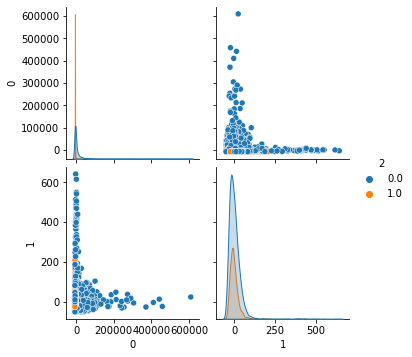

In [120]:
df = pd.DataFrame(np.concatenate((pca_train, (y_train[:, np.newaxis]).astype('int')), axis=1))
sns.pairplot(df, hue=2)

In [122]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f1_score(pred, y_test))

0.7246550689862027


In [126]:
acc = []
for i in range(10, 300, 20):
    preds = 0
    my_clf = GradientBoostingClassifier(n_estimators=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        preds += accuracy_score(y_pred=my_clf.predict(X_test_), y_true=y_test_)
    acc.append(preds / 3)
    print(preds / 3)

0.8136903170002573
0.8304634625233644
0.8304623838273261
0.8303488895941507
0.8329560593939286
0.8342020303679133
0.8331820076890994
0.830462075628458
0.835788406991707
0.8293293677384975
0.8314820212575545
0.8304627690759112
0.8295547766856494
0.83567599145457
0.8331828167111283


In [130]:
print(list(range(10, 300, 20)))

[10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290]


In [135]:
acc = []
f1_s = []
loss = ['deviance', 'exponential']
for i in loss:
    preds = 0
    f1 = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss=i)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f1 += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1_s.append(f1/3)
    print(f1/3)
print(acc)
print(f1)
best_loss = loss[np.argmax(f1)]
print(best_loss)

0.6815924428837453
0.6830748790935645
[0.8306897190174034, 0.8320485678268273]
2.0492246372806933
deviance


In [137]:
preds = 0
f1 = 0
my_clf = GradientBoostingClassifier(n_estimators=170)
for ind_train, ind_test in kfold.split(X_train, y_train):
    X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
    my_clf.fit(X_train_, y_train_)
    pred = my_clf.predict(X_test_)
    preds += accuracy_score(y_pred=pred, y_true=y_test_)
    f1 += f1_score(y_test_, pred)
print(f1/3)
print(preds/3)

0.6774643416887886
0.8291031112444586


In [139]:
acc = []
f1 = []
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]
for lr in learning_rate:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=lr)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
print(acc)
print(f1)
best_lr = learning_rate[np.argmax(f1)]
print('Лучший learning_rate =', best_lr)

[0.7233697108162316, 0.7958972258480536, 0.8295565103042825, 0.8319358055659638, 0.8343152934519376, 0.831595592540447, 0.8285365646751858]
[0.0, 0.4534568656008941, 0.6628114612087938, 0.6854917808743365, 0.6870409407846347, 0.68051333429944, 0.6719543235622942]
Лучший learning_rate = 0.1


In [140]:
acc = []
f1 = []
percent = np.arange(0.1, 1.1, 0.1)
for p in percent:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=p)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
    print(f/3)
print(acc)
print(f1)
best_p = percent[np.argmax(f1)]
print('Лучший subsample  =', best_p)

0.67099909069933
0.6757312065299973
0.6735076298085801
0.6814471028932229
0.6801710352574449
0.6865750304173991
0.6844950168455003
0.6859248218385771
0.6806388260996762
0.6862481040718568
[0.8246820370065168, 0.8264946701243497, 0.8274023157908849, 0.8311413844585944, 0.8305755313367748, 0.833975311575572, 0.8329553659464753, 0.8337488624572402, 0.8306884091722141, 0.833749594429552]
[0.67099909069933, 0.6757312065299973, 0.6735076298085801, 0.6814471028932229, 0.6801710352574449, 0.6865750304173991, 0.6844950168455003, 0.6859248218385771, 0.6806388260996762, 0.6862481040718568]
Лучший subsample  = 0.2


In [141]:
best_p = percent[np.argmax(f1)]
print('Лучший subsample  =', best_p)

Лучший subsample  = 0.6


In [142]:
acc = []
f1 = []
depth = np.arange(1, 10)
for d in depth:
    preds = 0
    f = 0
    my_clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=d)
    for ind_train, ind_test in kfold.split(X_train, y_train):
        X_train_, X_test_, y_train_, y_test_ = X_train[ind_train], X_train[ind_test], y_train[ind_train], y_train[ind_test]
        my_clf.fit(X_train_, y_train_)
        pred = my_clf.predict(X_test_)
        preds += accuracy_score(y_pred=pred, y_true=y_test_)
        f += f1_score(y_test_, pred)
    acc.append(preds / 3)
    f1.append(f/3)
    print(f/3)
print(acc)
print(f1)
best_d = depth[np.argmax(f1)]
print('Лучший depth =', best_d)

0.6696315864548428
0.6819512373522215
0.682180332006165
0.6856937637694757
0.6824441508151011
0.6794529390746749
0.6770784805014909
0.6846093153684416
0.685099540473359
[0.8245679263756052, 0.8310285836728721, 0.830803521449447, 0.8334088035311576, 0.8320491842245635, 0.8325017357375003, 0.8315957081150226, 0.8349957965526879, 0.8351092137361462]
[0.6696315864548428, 0.6819512373522215, 0.682180332006165, 0.6856937637694757, 0.6824441508151011, 0.6794529390746749, 0.6770784805014909, 0.6846093153684416, 0.685099540473359]
Лучший depth = 4


In [143]:
clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=4)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.838814600650524
0.7397899649941657


In [144]:
clf = GradientBoostingClassifier(n_estimators=170, loss='exponential', learning_rate=0.1, subsample=0.6, max_depth=4)
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_scaler.fit(X_train), test_scaler.fit(X_test)
X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))
print(f1_score(y_test, pred))

0.8192988796530538
0.6798975672215108


In [25]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [261]:
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))

In [224]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=9,
                            #learning_rate=0.01,
                            eta=0.1,
                            verbose=False, 
                            iterations=600, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
# train_scaler, test_scaler = StandardScaler(), StandardScaler()
# train_scaler.fit(X_train), test_scaler.fit(X_test)
# X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
X_train, y_train = parser_groups_train(range(1, 100))
X_test, y_test = parser_groups_train(range(100, 130))
my_clf.fit(X_train, y_train, plot=True)
print(f1_score(my_clf.predict(X_test), y_test))
print(f1_score(my_clf.predict(X_train), y_train))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7414806110458285
1.0


In [269]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=6,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=2000, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
# train_scaler, test_scaler = StandardScaler(), StandardScaler()
# train_scaler.fit(X_train), test_scaler.fit(X_test)
# X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(pred, y_test))
print(f1_score(my_clf.predict(X_train), y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7530936947554507
0.8535419382877011


In [234]:
for i in np.arange(0.01, 0.1, 0.01):
    my_clf = CatBoostClassifier(loss_function='Logloss',
                                depth=9,
                                learning_rate=i,
                                verbose=False, 
                                iterations=1000, 
                                leaf_estimation_method = 'Gradient',
                                random_seed=42,
                                custom_loss=['F1', 'Precision', 'Recall'])
    # train_scaler, test_scaler = StandardScaler(), StandardScaler()
    # train_scaler.fit(X_train), test_scaler.fit(X_test)
    # X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
    my_clf.fit(X_train, y_train, plot=True)
    pred = my_clf.predict(X_test)
    print(f1_score(pred, y_test))
    print(f1_score(my_clf.predict(X_train), y_train))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7489711934156378
0.8829373650107992


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7439670394349618
0.9593908629441624


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.747957992998833
0.9869646182495345


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.743362831858407
0.9965156794425087


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7447058823529411
0.9993868792152054


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.73943661971831
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7412177985948478
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7489711934156378
1.0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.7460410557184751
1.0


In [107]:
print(f1_score(my_clf.predict(X_test), y_test))

0.7027406886858748


In [93]:
f1_score(my_clf.predict(X_test[:1000,:53]), y_test[:1000])

0.6466666666666667

In [96]:
X_train[:,:53].shape

(8901, 53)

In [ ]:
my_clf = CatBoostClassifier(loss_function='Logloss',
                            depth=9,
                            learning_rate=0.01,
                            verbose=False, 
                            iterations=500, 
                            leaf_estimation_method = 'Gradient',
                            random_seed=42,
                            custom_loss=['F1', 'Precision', 'Recall'])
train_scaler, test_scaler = StandardScaler(), StandardScaler()
train_scaler.fit(X_train), test_scaler.fit(X_test)
X_train, X_test = train_scaler.transform(X_train), test_scaler.transform(X_test)
my_clf.fit(X_train, y_train, plot=True)
pred = my_clf.predict(X_test)
print(f1_score(pred, y_test))
print(f1_score(my_clf.predict(X_train), y_train))

In [76]:
pred

array([0, 1, 0, ..., 1, 1, 0])

In [81]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [82]:
y_test.shape

(2589,)

In [83]:
pred.shape

(8901,)

(array([1980.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         609.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

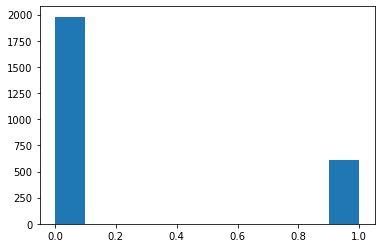

In [108]:
plt.hist(pred)

(array([1775.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         814.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

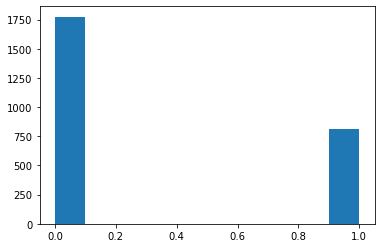

In [109]:
plt.hist(y_test)

In [110]:
np.sum(np.abs(y_test - pred))

423